Model has been saved as 'polynomial_regression_degree_3.pkl'
Mean Squared Error: 0.0050620594413501386
R² Score: 0.682833762103234


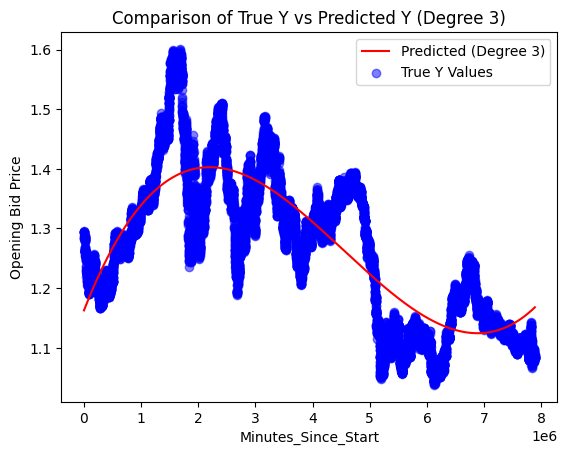


Comparison of predicted y values and actual y values (if available):
x = 180.0 -> Predicted y = 1.1625042310219194, Actual y = 1.2851


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pickle

# Load the data
df = pd.read_csv('eurusd_hour.csv')

# Rename columns to more descriptive names
df.rename(columns={
    'BO': 'Opening bid price',
    'BH': 'Highest bid price',
    'BL': 'Lowest bid price',
    'BC': 'Closing bid price',
    'BCh': 'Change between bid open and close price',
    'AO': 'Opening ask price',
    'AH': 'Highest ask price',
    'AL': 'Lowest ask price',
    'AC': 'Closing ask price',
    'ACh': 'Change between ask open and close price'
}, inplace=True)

# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the datetime column to a numeric format (e.g., timestamp)
df['Timestamp'] = df['Datetime'].astype('int64') // 10**9  # Convert to seconds since epoch

# Alternatively, you could calculate the minutes since the start of the data
df['Minutes_Since_Start'] = (df['Datetime'] - df['Datetime'].min()).dt.total_seconds() / 60

# Drop the original Date and Time columns
df = df.drop(columns=['Date', 'Time', 'Datetime'])

# Feature selection
x1 = df[['Minutes_Since_Start']]
y1 = df[['Opening bid price']]

# Split the data into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

# Get user input for the degree of the polynomial
degree = int(input("Enter the polynomial degree you want to use: "))

# Create polynomial features based on user input
poly = PolynomialFeatures(degree=degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Fit the model
model = LinearRegression()
model.fit(x_train_poly, y_train)

# Save the model to a file using pickle
model_filename = f'polynomial_regression_degree_{degree}.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model has been saved as '{model_filename}'")

# Predict using the model on the test data
y_test_pred = model.predict(x_test_poly)

# Calculate metrics
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Sort the test values for better visualization
sort_axis = np.argsort(x_test['Minutes_Since_Start'].values)
x_test_sorted = x_test['Minutes_Since_Start'].values[sort_axis]
y_test_pred_sorted = y_test_pred[sort_axis]
y_test_sorted = y_test.values[sort_axis]

# Plot the polynomial fit (predicted y values)
plt.plot(x_test_sorted, y_test_pred_sorted, label=f'Predicted (Degree {degree})', color='red')

# Plot the actual test data (true y values)
plt.scatter(x_test_sorted, y_test_sorted, color='blue', label='True Y Values', alpha=0.5)

# Plot settings
plt.xlabel('Minutes_Since_Start')
plt.ylabel('Opening Bid Price')
plt.title(f'Comparison of True Y vs Predicted Y (Degree {degree})')
plt.legend()
plt.show()

# --- Predict y for new x values based on user input ---

# Load the model from the file (already loaded, but to demonstrate use)
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Get user input for new x values (input should be space-separated)
new_x_values_input = input("Enter new x values (Minutes_Since_Start) separated by spaces: ")
new_x_values = np.array([[float(x)] for x in new_x_values_input.split()])

# Transform the new x values to polynomial features
new_x_poly = poly.transform(new_x_values)

# Predict y values using the loaded model
new_y_pred = loaded_model.predict(new_x_poly)

# Print the predicted y values and the actual y values if available
print("\nComparison of predicted y values and actual y values (if available):")
for i, x_val in enumerate(new_x_values):
    actual_y_value = df.loc[df['Minutes_Since_Start'] == x_val[0], 'Opening bid price']
    if not actual_y_value.empty:
        print(f"x = {x_val[0]} -> Predicted y = {new_y_pred[i][0]}, Actual y = {actual_y_value.values[0]}")
    else:
        print(f"x = {x_val[0]} -> Predicted y = {new_y_pred[i][0]}, Actual y = Not available in dataset")
